In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import mlab
from matplotlib.ticker import FuncFormatter
matplotlib.style.use('ggplot')
import sqlite3
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Importing the Dataset and performing EDA

In [ ]:
url = 'https://data.ny.gov/api/views/uu7b-3kff/rows.csv?accessType=DOWNLOAD'
mta_2021 = pd.read_csv(url)

In [ ]:
mta_2021.head()

,C/A,Unit,SCP,Station,Line Name,Division,Date,Time,Description,Entries,Exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/20/2021,00:00:00,REGULAR,7621953,2607461
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/20/2021,04:00:00,REGULAR,7621962,2607463
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/20/2021,08:00:00,REGULAR,7621971,2607505
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/20/2021,12:00:00,REGULAR,7622037,2607607
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/20/2021,16:00:00,REGULAR,7622194,2607644


Standardizing column names


In [ ]:
def standardize_column_names(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r'\s', '_', regex=True)  # Replace any whitespace character(s)
    )
    return df


In [ ]:
standardize_column_names(mta_2021)
mta_2021.head()

,c/a,unit,scp,station,line_name,division,date,time,description,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/20/2021,00:00:00,REGULAR,7621953,2607461
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/20/2021,04:00:00,REGULAR,7621962,2607463
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/20/2021,08:00:00,REGULAR,7621971,2607505
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/20/2021,12:00:00,REGULAR,7622037,2607607
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/20/2021,16:00:00,REGULAR,7622194,2607644


In a perfect world we would have a 1-to-1 ratio for entries and exits. Everyone person entering and exiting from the train station would be accounted for. As we can see, that is not the case. The average for entries is significantly higher than the average number of exits. This suggests that a large amount of people who leave are not being tracked.

The missing information is likely due to people opting to exit from emergency exit doors which cannot record how many people pass through it, both for entries and exits.

In [ ]:
mta_2021['entries'].describe()

,entries
count,1.089730e+07
mean,4.192604e+07
std,2.191167e+08
min,0.000000e+00
25%,2.247450e+05
50%,1.423658e+06
75%,6.068410e+06
max,2.147432e+09


In [ ]:
mta_2021['exits'].describe()

,exits
count,1.089730e+07
mean,3.368666e+07
std,1.936134e+08
min,0.000000e+00
25%,1.012620e+05
50%,8.668170e+05
75%,4.010583e+06
max,2.133797e+09


Creating a column that indentifies each individual turnstile

In [ ]:
mta_2021['turnstile_id'] = mta_2021['c/a'] + ' ' + mta_2021['unit'] + ' ' + mta_2021['scp']
mta_2021['turnstile_id'].head()

,turnstile_id
0,A002 R051 02-00-00
1,A002 R051 02-00-00
2,A002 R051 02-00-00
3,A002 R051 02-00-00
4,A002 R051 02-00-00


In [ ]:
mta_2021.isnull().sum()

,0
c/a,0
unit,0
scp,0
station,0
line_name,0
division,0
date,0
time,0
description,0
entries,0


There are no nulls in our dataset but is this really true?

In [ ]:
zero_counts = {
    'entries': (mta_2021['entries'] == 0).sum(),
    'exits': (mta_2021['exits'] == 0).sum()
}
print(zero_counts)

{'entries': np.int64(152568), 'exits': np.int64(438343)}


In [ ]:
mta_2021.groupby('turnstile_id').count()

,c/a,unit,scp,station,line_name,division,date,time,description,entries,exits
turnstile_id,,,,,,,,,,,
A002 R051 02-00-00,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181
A002 R051 02-00-01,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181,2181
A002 R051 02-03-00,2183,2183,2183,2183,2183,2183,2183,2183,2183,2183,2183
A002 R051 02-03-01,2182,2182,2182,2182,2182,2182,2182,2182,2182,2182,2182
A002 R051 02-03-02,2182,2182,2182,2182,2182,2182,2182,2182,2182,2182,2182
...,...,...,...,...,...,...,...,...,...,...,...
TRAM2 R469 00-00-01,2190,2190,2190,2190,2190,2190,2190,2190,2190,2190,2190
TRAM2 R469 00-03-00,2190,2190,2190,2190,2190,2190,2190,2190,2190,2190,2190
TRAM2 R469 00-03-01,2190,2190,2190,2190,2190,2190,2190,2190,2190,2190,2190


I'm going to find the busiest stations. I think it's useful to visualize which areas are extremely likely to have the highest rates of fare evasion because of their overall traffic.

In [ ]:
# Sum entries and exits for each station
busiest_stations = (
    mta_2021.groupby('station')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])  # total traffic
    .sort_values('total', ascending=False)
)

# Show top 10 busiest stations
print(busiest_stations.head(10))


                        entries           exits           total
station                                                        
42 ST-PORT AUTH  16514877897338  13664872532966  30179750430304
23 ST            12543510972170  12640410407205  25183921379375
125 ST           14046548713019  10850183061808  24896731774827
DEKALB AV        14274961061269   9566228500316  23841189561585
34 ST-PENN STA   10252941502503  11295841716084  21548783218587
CANAL ST          8849190129354  11907502979359  20756693108713
161/YANKEE STAD  10287727190889  10090934112316  20378661303205
FULTON ST         8888912812053   9509657289051  18398570101104
TIMES SQ-42 ST    9327601113525   7552822324354  16880423437879
183 ST           10052148666846   6019017915248  16071166582094


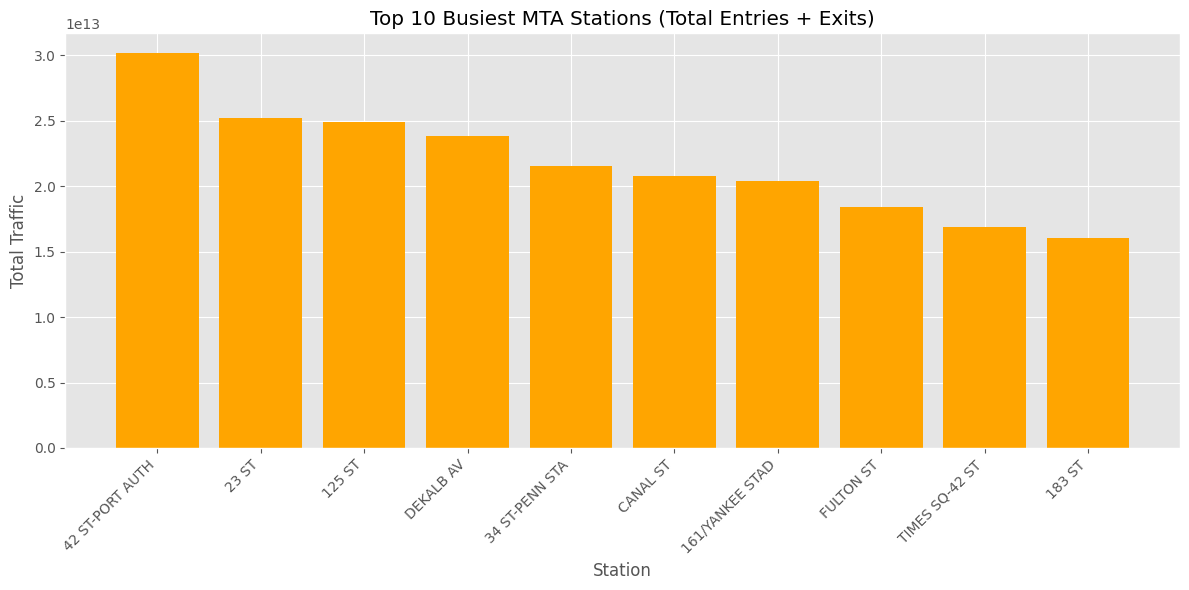

In [ ]:
# Getting the top 10 busiest stations
top10 = busiest_stations.head(10).reset_index()


plt.figure(figsize=(12, 6))
plt.bar(top10['station'], top10['total'], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Busiest MTA Stations (Total Entries + Exits)")
plt.xlabel("Station")
plt.ylabel("Total Traffic")
plt.tight_layout()
plt.show()


I'm going to do the same for the train lines to see which are used the most.

In [ ]:
busiest_lines = (
    mta_2021.groupby('line_name')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
    .sort_values('total', ascending=False)
)

In [ ]:
# Step 1: Make a copy to avoid changing the original
lines_expanded = mta_2021.copy()

# Step 2: Split by space (e.g., "A C E" → ["A", "C", "E"])
lines_expanded['line_name'] = lines_expanded['line_name'].str.split()

# Step 3: Explode into multiple rows
lines_expanded = lines_expanded.explode('line_name')

# Step 4: Group by each individual line
busiest_individual_lines = (
    lines_expanded.groupby('line_name')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
    .sort_values('total', ascending=False)
)


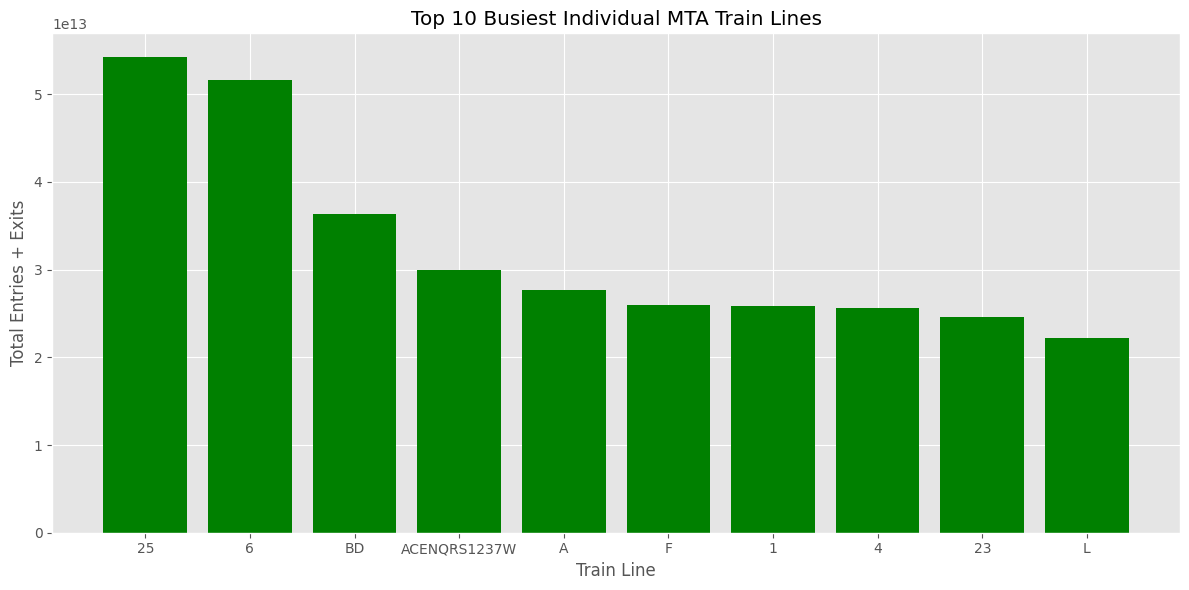

In [ ]:
top_lines = busiest_individual_lines.head(10).reset_index()

plt.figure(figsize=(12, 6))
plt.bar(top_lines['line_name'], top_lines['total'], color='green')
plt.xticks(rotation=0)
plt.title("Top 10 Busiest Individual MTA Train Lines")
plt.xlabel("Train Line")
plt.ylabel("Total Entries + Exits")
plt.tight_layout()
plt.show()


Now I'm analyzing by time. This can give us an idea of when the MTA should request additional law enforcement presence to reduce the amount of fare evaders.

In [ ]:
# Strip AM/PM from the time strings
mta_2021['time'] = mta_2021['time'].str.replace(r'\s?(AM|PM)', '', regex=True)

# Now combine and convert
mta_2021['datetime'] = pd.to_datetime(mta_2021['date'] + ' ' + mta_2021['time'])


Extracting parts of the datetime obj so we can look at what days were most busy and what hours of the day were most busy.

In [ ]:
mta_2021['date_only'] = mta_2021['datetime'].dt.date
mta_2021['hour'] = mta_2021['datetime'].dt.hour

In [ ]:
daily_traffic = (
    mta_2021.groupby('date_only')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
)

In [ ]:
hourly_traffic = (
    mta_2021.groupby('hour')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
)


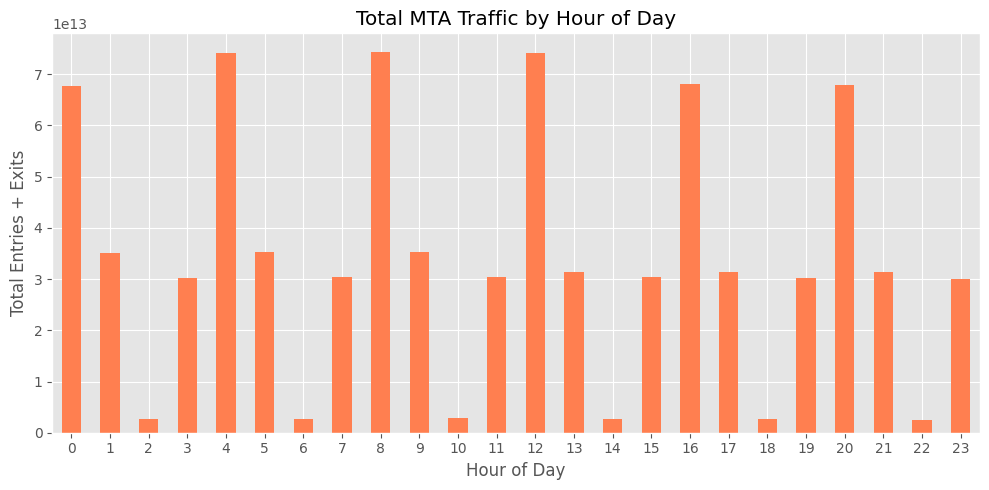

In [ ]:
hourly_traffic.plot(
    y='total', kind='bar', legend=False, figsize=(10, 5), color='coral',
    title='Total MTA Traffic by Hour of Day'
)
plt.xlabel("Hour of Day")
plt.ylabel("Total Entries + Exits")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

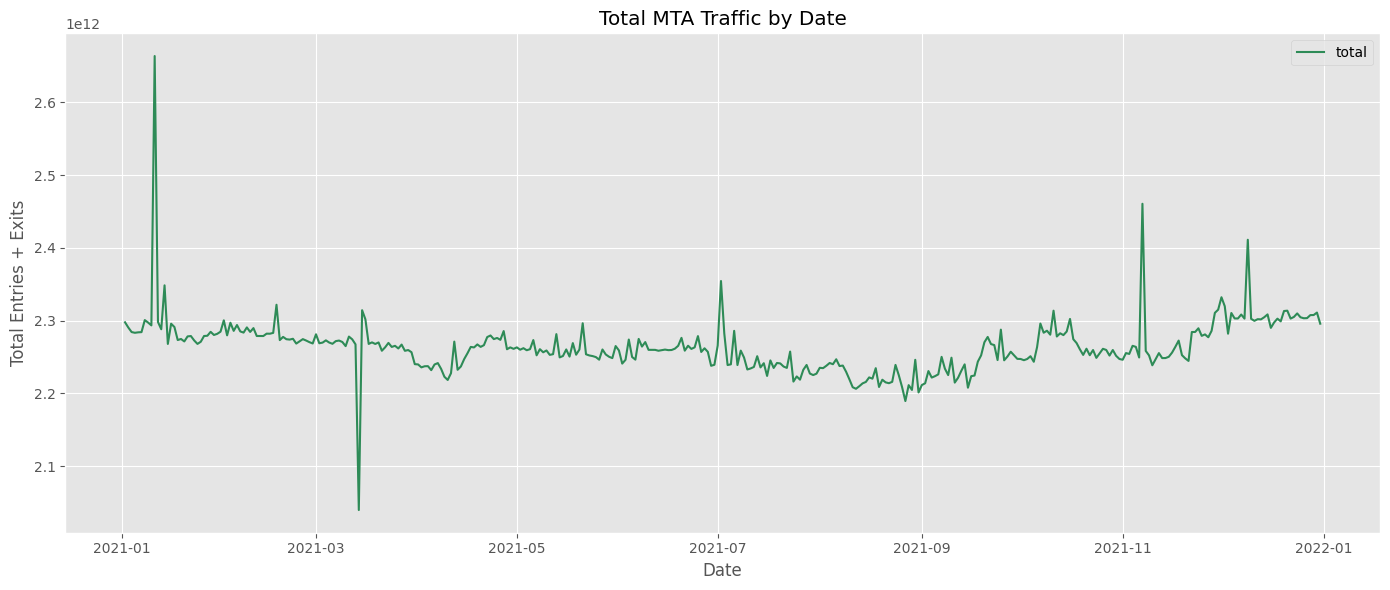

In [ ]:
daily_traffic.plot(
    y='total', figsize=(14, 6), title='Total MTA Traffic by Date', color='seagreen'
)
plt.xlabel("Date")
plt.ylabel("Total Entries + Exits")
plt.tight_layout()
plt.show()


Which days of the week are the most busy? Additional law enforcement then could also be beneficial.

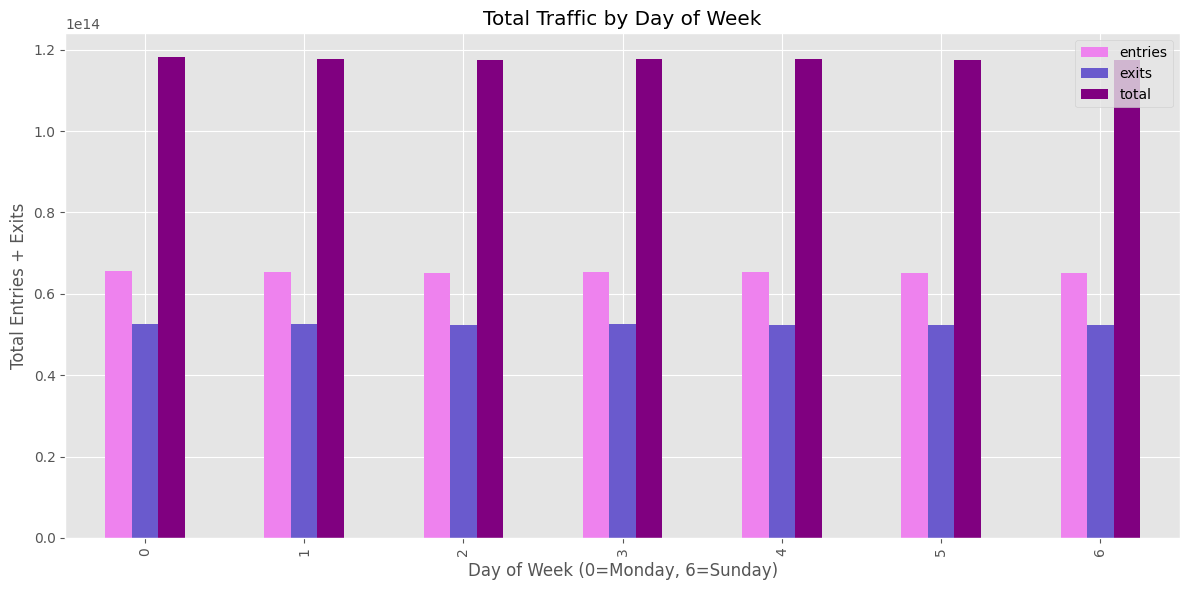

In [ ]:
mta_2021['weekday'] = mta_2021['datetime'].dt.weekday  # Monday = 0, Sunday = 6

weekly_traffic = (
    mta_2021.groupby('weekday')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
)

# Plot
weekly_traffic.plot(kind='bar', figsize=(12, 6), title='Total Traffic by Day of Week', color=['violet', 'slateblue', 'purple'])
plt.xlabel("Day of Week (0=Monday, 6=Sunday)")
plt.ylabel("Total Entries + Exits")
plt.tight_layout()
plt.show()


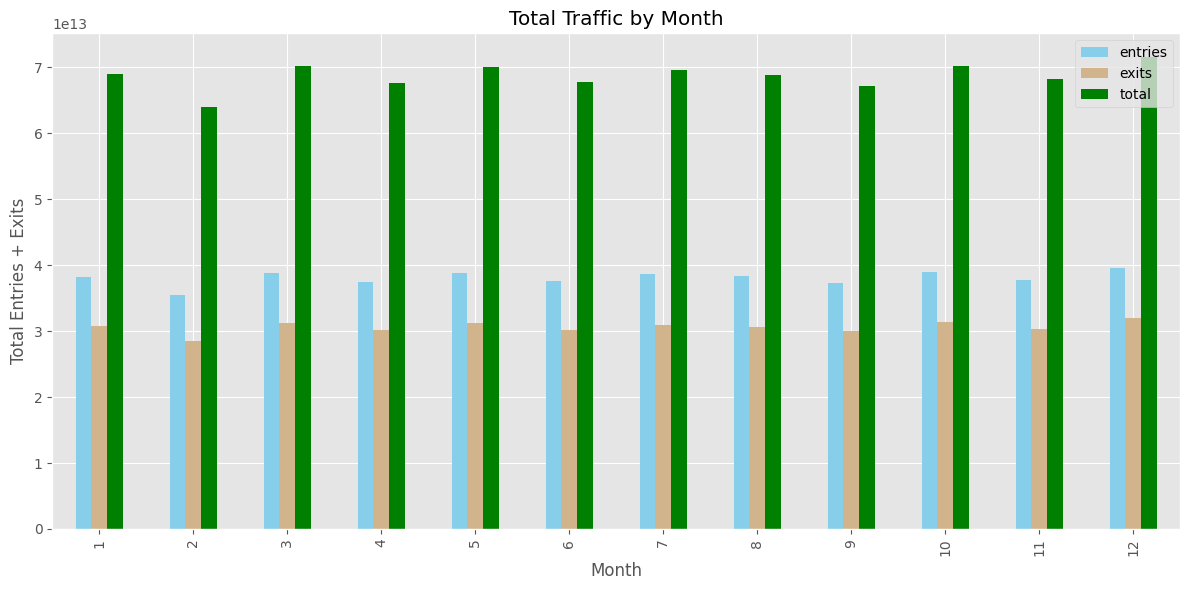

In [ ]:
mta_2021['month'] = mta_2021['datetime'].dt.month

monthly_traffic = (
    mta_2021.groupby('month')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
)

monthly_traffic.plot(kind='bar', figsize=(12, 6), title='Total Traffic by Month', color=['skyblue', 'tan', 'green'])

plt.xlabel('Month')
plt.ylabel('Total Entries + Exits')
plt.tight_layout()
plt.show()


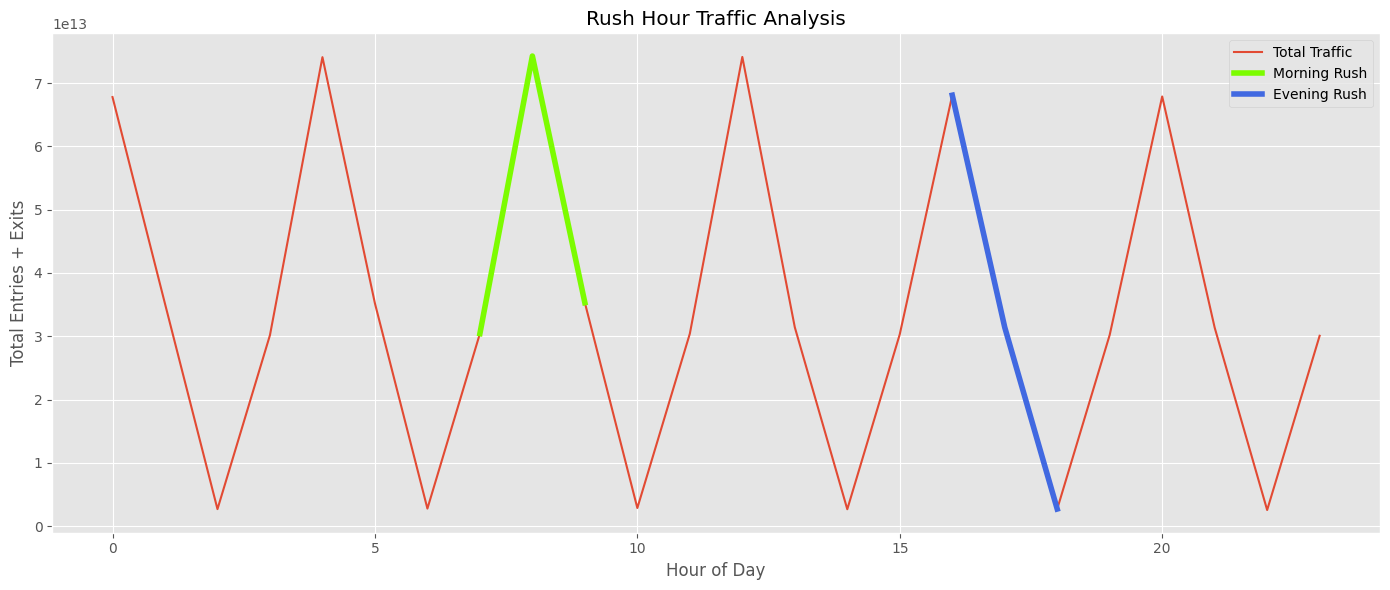

In [ ]:
# Group by hour and summarize
hourly_traffic = (
    mta_2021.groupby('hour')[['entries', 'exits']]
    .sum()
    .assign(total=lambda df: df['entries'] + df['exits'])
)

# Highlight rush hours (e.g., 7AM-9AM and 4PM-6PM)
rush_hours = hourly_traffic.loc[(hourly_traffic.index >= 7) & (hourly_traffic.index <= 9)]
evening_rush = hourly_traffic.loc[(hourly_traffic.index >= 16) & (hourly_traffic.index <= 18)]

# Plot
plt.figure(figsize=(14, 6))
plt.plot(hourly_traffic.index, hourly_traffic['total'], label='Total Traffic')
plt.plot(rush_hours.index, rush_hours['total'], label='Morning Rush', color='lawngreen', linewidth=4)
plt.plot(evening_rush.index, evening_rush['total'], label='Evening Rush', color='royalblue', linewidth=4)
plt.title('Rush Hour Traffic Analysis')
plt.xlabel('Hour of Day')
plt.ylabel('Total Entries + Exits')
plt.legend()
plt.tight_layout()
plt.show()